In [1]:
from load_resp_stim import *
from sklearn.linear_model import LinearRegression
from nilearn.glm.first_level import FirstLevelModel
from nilearn import image, masking, plotting, maskers
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, KMeans

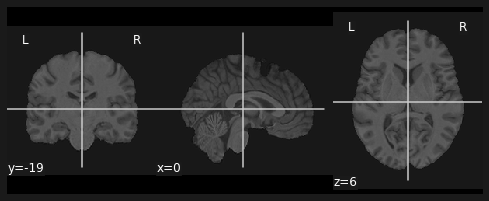

loading the data of: 
      group     race gender  age origin
99  chronic  1 and 6      M   41      4
Paths found for func_file and resp_file:  /rds/project/rds-3IOyKgCQu4I/sbp/openpain.org/subacute_longitudinal_study/sub-100/ses-visit1/func/sub-100_ses-visit1_task-sp_run-01_bold.nii.gz /rds/project/rds-3IOyKgCQu4I/sbp/openpain.org/subacute_longitudinal_study/sub-100/ses-visit1/func/sub-100_ses-visit1_task-sp_run-01_resp.tsv.gz
func_file img shape (64, 64, 36, 244)
len of responses:  8784
range of responses:  25.54 81.33


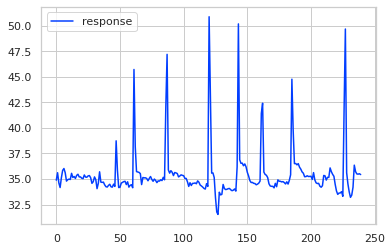

In [2]:
subject_id = "100"
session_vist = 1
runNumber = 1
run = f'sp_run-0{runNumber}'
session_vist_string = str(session_vist)

anat_file = "output/sub-" + subject_id + "/anat/sub-" + subject_id + "_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
func_file = "output_resampled/sub-" + subject_id + "/ses-visit" + session_vist_string + "/func/sub-" + subject_id + "_ses-visit" + session_vist_string + f"_task-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
mask_file = "output_resampled/sub-" + subject_id + "/ses-visit" + session_vist_string + "/func/sub-" + subject_id + "_ses-visit" + session_vist_string + f"_task-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
conf_file = "output/sub-" + subject_id + "/ses-visit" + session_vist_string + "/func/sub-" + subject_id + "_ses-visit" + session_vist_string + f"_task-{run}_desc-confounds_timeseries.tsv"
# func_file = "output/sub-" + subject_id + "/ses-visit" + session_vist_string + "/func/sub-" + subject_id + "_ses-visit" + session_vist_string + "_task-mv_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"

anat = nb.load(anat_file)
plotting.plot_anat(anat)
plt.show()
func = nb.load(func_file)
mask = nb.load(mask_file)

anat_data = anat.get_fdata()

func_data = func.get_fdata()
mask_data = mask.get_fdata()

downsampled_response = load_sp_func(subject_id, visit = session_vist,run=runNumber)
plt.plot(range(len(downsampled_response[4:])), downsampled_response[4:], label="response")
plt.legend()
plt.show()

In [3]:
print(anat.shape, func.shape, mask.shape)

(193, 229, 193) (99, 117, 95, 244) (99, 117, 95)


In [4]:
conf = pd.read_csv(conf_file, sep='\t')
conf.head()

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,aroma_motion_42,aroma_motion_44,aroma_motion_46,aroma_motion_48,aroma_motion_49,aroma_motion_51,aroma_motion_52,aroma_motion_53,aroma_motion_54,aroma_motion_55
0,1331.758434,NaN,1.773581e+06,NaN,2541.560304,NaN,6.459529e+06,NaN,1090.769525,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1052.238627,-279.519807,1.107206e+06,78131.322511,1470.808622,-1070.751682,2.163278e+06,1.146509e+06,950.815015,-139.954511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1030.273502,-21.965125,1.061463e+06,482.466716,1345.530498,-125.278124,1.810452e+06,1.569461e+04,949.420427,-1.394588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1023.505884,-6.767618,1.047564e+06,45.800656,1328.390667,-17.139831,1.764622e+06,2.937738e+02,949.656663,0.236236,...,-2.300589,0.261366,-1.739341,0.509664,-0.035159,-0.896513,-1.208238,-2.076312,2.111689,-1.020270
4,1021.504276,-2.001609,1.043471e+06,4.006437,1306.414845,-21.975822,1.706720e+06,4.829368e+02,948.426244,-1.230419,...,-1.030375,-0.319872,-1.718979,-0.391277,-0.412933,-1.159536,-0.988641,-1.274254,-0.034052,0.415901


## Running a First Level GLM

In [6]:
from nilearn.glm.first_level import make_first_level_design_matrix

frame_times = np.arange(244) * 2

df_events = pd.DataFrame()
df_events["onset"] = frame_times
df_events["duration"] = 2
df_events['modulation'] = downsampled_response
#df_events['Predictions'] = 
#df_events['PredictionErrors'] = 

design_matrices = make_first_level_design_matrix(frame_times, df_events,
                          drift_model='cosine')

A 'modulation' column was found in the given events data and is used.


<AxesSubplot:label='conditions', ylabel='scan number'>

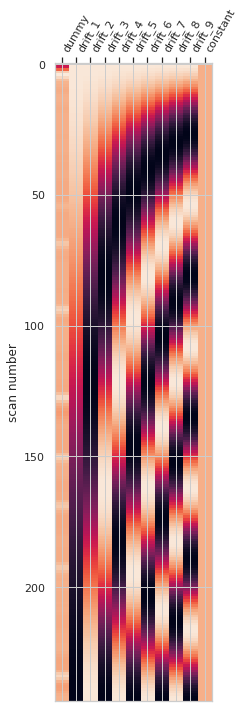

In [7]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrices)

In [23]:
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(subject_data, design_matrices=design_matrices)

NameError: name 'subject_data' is not defined

In [ ]:
fmri_glm.compute_contrast()